In [ ]:
# default_exp augmentation

# Data Augmentation

> Improve predictions doing data augmentation

In [ ]:
# export
import random
import math
import numpy as np
import pandas as pd
from rdkit import Chem

In [ ]:
# hide
from rxn_yields.data import generate_buchwald_hartwig_rxns

In [ ]:
# hide
test_df = pd.DataFrame({"Ligand":{"0":"CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC","1":"CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC","2":"CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2","3":"CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C(OC)=CC=C2OC","4":"CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC"},"Additive":{"0":"CC1=CC(C)=NO1","1":"O=C(OC)C1=CC=NO1","2":"O=C(OC)C1=CC=NO1","3":"CCOC(C1=CON=C1)=O","4":"CC1=CC(C)=NO1"},"Base":{"0":"CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC","1":"CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC","2":"CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC","3":"CN1CCCN2C1=NCCC2","4":"CN1CCCN2C1=NCCC2"},"Aryl halide":{"0":"ClC1=NC=CC=C1","1":"BrC1=NC=CC=C1","2":"IC1=CC=C(CC)C=C1","3":"ClC1=CC=C(C(F)(F)F)C=C1","4":"ClC1=CC=C(OC)C=C1"},"Output":{"0":70.41045785,"1":11.06445724,"2":10.22354965,"3":20.0833829,"4":0.492662711}})
converted_rxns = generate_buchwald_hartwig_rxns(test_df)
df = pd.DataFrame({'text': converted_rxns, 'labels': test_df['Output'].values})


## Smiles Augmentations

In [ ]:
# export
def randomize_smiles(smiles, random_type="rotated", isomericSmiles=True):
    """
    From: https://github.com/undeadpixel/reinvent-randomized and https://github.com/GLambard/SMILES-X
    Returns a random SMILES given a SMILES of a molecule.
    :param mol: A Mol object
    :param random_type: The type (unrestricted, restricted, rotated) of randomization performed.
    :return : A random SMILES string of the same molecule or None if the molecule is invalid.
    """
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    if random_type == "unrestricted":
        return Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=isomericSmiles)
    elif random_type == "restricted":
        new_atom_order = list(range(mol.GetNumAtoms()))
        random.shuffle(new_atom_order)
        random_mol = Chem.RenumberAtoms(mol, newOrder=new_atom_order)
        return Chem.MolToSmiles(random_mol, canonical=False, isomericSmiles=isomericSmiles)
    elif random_type == 'rotated':
        n_atoms = mol.GetNumAtoms()
        rotation_index = random.randint(0, n_atoms-1)
        atoms = list(range(n_atoms))
        new_atoms_order = (atoms[rotation_index%len(atoms):]+atoms[:rotation_index%len(atoms)])
        rotated_mol = Chem.RenumberAtoms(mol,new_atoms_order)
        return Chem.MolToSmiles(rotated_mol, canonical=False, isomericSmiles=isomericSmiles)
    raise ValueError("Type '{}' is not valid".format(random_type))

## Precursors permutations 

In [ ]:
# export
from itertools import permutations

def precursor_permutation_given_index(precursor_list, permutation_index):
    """
    Return permutation of list given index. Inspired by
    https://stackoverflow.com/questions/5602488/random-picks-from-permutation-generator.
    :param precursor_list: List of molecules
    :param permutation_index: Permutation index
    :return : Permuted list
    """
    
    precursor_list = precursor_list[:]
    for i in range(len(precursor_list)-1):
        permutation_index, j = divmod(permutation_index, len(precursor_list)-i)
        precursor_list[i], precursor_list[i+j] = precursor_list[i+j], precursor_list[i]
    return precursor_list

def randomize_rxn(rxn, random_type):
    """
    Split reaction into precursors and products, then randomize all molecules.
    """
    precursors, product = rxn.split('>>')
    precursors_list = precursors.split('.')
    
    randomized_precursors = [randomize_smiles(precursor, random_type) for precursor in precursors_list]
    randomized_product = randomize_smiles(product, random_type)
    return f"{'.'.join(randomized_precursors)}>>{randomized_product}"


def do_randomizations_on_df(df, n_randomizations=1, random_type='rotated', seed=42):
    """
    Randomize all molecule SMILES of the reactions in a dataframe. 
    Expected to have column 'text' with the reactions and 'label' with the property to predict.
    """
    new_texts = []
    new_labels = []
    random.seed(seed)
    
    for i, row in df.iterrows():
        if random_type != '':
            randomized_rxns = [randomize_rxn(row['text'], random_type=random_type) for i in range(n_randomizations)]
        new_texts.extend(randomized_rxns)
        new_labels.extend([row['labels']]*len(randomized_rxns))
    return pd.DataFrame({'text': new_texts, 'labels': new_labels})


def do_random_permutations_on_df(df, n_permutations=1, fixed=False, random_type='', seed=42):
    """
    Generate `n_permutations` permutations of the precursors per reaction in a dataframe.
    Expected to have column 'text' with the reactions and 'label' with the property to predict.
    
    """
    
    new_texts = []
    new_labels = []
    
    for i, row in df.iterrows():
        
        precursors, product = row['text'].split('>>')
        precursors_list = precursors.split('.')
        if fixed:
            random.seed(seed)
        else:
            random.seed(i+seed)
        total_permutations = range(math.factorial(len(precursors_list)))
        
        permutation_indices = random.sample(total_permutations, n_permutations)
        permuted_rxns = []
        
        for idx in permutation_indices:
            permuted_precursors = precursor_permutation_given_index(precursors_list, idx)
            permuted_rxns.append(f"{'.'.join(permuted_precursors)}>>{product}")
        if random_type != '':
            permuted_rxns = [randomize_rxn(rxn, random_type=random_type) for rxn in permuted_rxns]
        new_texts.extend(permuted_rxns)
        new_labels.extend([row['labels']]*len(permuted_rxns))
    return pd.DataFrame({'text': new_texts, 'labels': new_labels})
        

In [ ]:
assert len(do_random_permutations_on_df(df,n_permutations=3)) == 3 * len(df)

In [ ]:
assert len(do_random_permutations_on_df(df,n_permutations=3, random_type='rotated')) == 3 * len(df)

In [ ]:
assert len(do_random_permutations_on_df(df,n_permutations=3, random_type='unrestricted')) == 3 * len(df)

In [ ]:
assert len(do_random_permutations_on_df(df,n_permutations=3, fixed=True, random_type='restricted')) == 3 * len(df)

In [ ]:
assert len(do_randomizations_on_df(df, n_randomizations=3, random_type='rotated')) == 3 * len(df)

## Comparison of the different SMILES augmentation techniques

We take the example of a caffeine molecule and generate all possible augmentation for `rotation`, `restricted_randomization` and `unrestricted_randomization`. Rotation rotates the starting atom for the generation of the SMILES and produces one string per atom in the SMILES. For the caffeine molecule with 14 atoms it yields 14 representations. In contrast, restricted and unrestricted randomisation produce ~76 different representations for the SMILES, and ~1.3k respectively.  

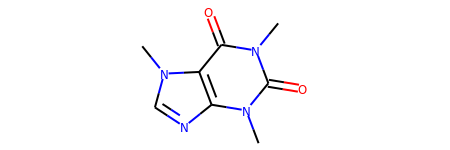

In [ ]:
example_smi = 'O=C1C2=C(N=CN2C)N(C(=O)N1C)C'
Chem.MolFromSmiles(example_smi)

In [ ]:
rotated_random_smiles = []
for i in range (500):
    rotated_random_smiles.append(randomize_smiles(example_smi))
print(len(set(rotated_random_smiles)))
set(rotated_random_smiles)

14


{'Cn1c(=O)c2c(ncn2C)n(C)c1=O',
 'Cn1c2c(=O)n(C)c(=O)n(C)c2nc1',
 'Cn1c2c(c(=O)n(C)c1=O)n(C)cn2',
 'O=c1c2c(ncn2C)n(C)c(=O)n1C',
 'O=c1n(C)c(=O)c2c(ncn2C)n1C',
 'c1(=O)c2c(ncn2C)n(C)c(=O)n1C',
 'c1(=O)n(C)c(=O)c2c(ncn2C)n1C',
 'c12c(ncn1C)n(C)c(=O)n(C)c2=O',
 'c12ncn(C)c1c(=O)n(C)c(=O)n2C',
 'c1n(C)c2c(=O)n(C)c(=O)n(C)c2n1',
 'n1(C)c(=O)c2c(ncn2C)n(C)c1=O',
 'n1(C)c(=O)n(C)c(=O)c2c1ncn2C',
 'n1(C)c2c(=O)n(C)c(=O)n(C)c2nc1',
 'n1cn(C)c2c(=O)n(C)c(=O)n(C)c12'}

In [ ]:
restricted_random_smiles = []
for i in range (500):
    restricted_random_smiles.append(randomize_smiles(example_smi, 'restricted'))
print(len(set(restricted_random_smiles)))
set(restricted_random_smiles)

75


{'Cn1c(=O)c2c(n(C)c1=O)ncn2C',
 'Cn1c(=O)c2c(ncn2C)n(C)c1=O',
 'Cn1c(=O)c2n(C)cnc2n(C)c1=O',
 'Cn1c(=O)n(C)c(=O)c2c1ncn2C',
 'Cn1c(=O)n(C)c(=O)c2n(C)cnc12',
 'Cn1c(=O)n(C)c(=O)c2n(C)cnc21',
 'Cn1c(=O)n(C)c2c(c1=O)n(C)cn2',
 'Cn1c(=O)n(C)c2c(n(C)cn2)c1=O',
 'Cn1c(=O)n(C)c2ncn(C)c2c1=O',
 'Cn1c2c(=O)n(C)c(=O)n(C)c2nc1',
 'Cn1c2c(c(=O)n(C)c1=O)n(C)cn2',
 'Cn1c2c(n(C)c(=O)n(C)c2=O)nc1',
 'Cn1c2c(n(C)cn2)c(=O)n(C)c1=O',
 'Cn1c2c(nc1)n(C)c(=O)n(C)c2=O',
 'Cn1c2ncn(C)c2c(=O)n(C)c1=O',
 'Cn1cnc2c1c(=O)n(C)c(=O)n2C',
 'Cn1cnc2n(C)c(=O)n(C)c(=O)c12',
 'Cn1cnc2n(C)c(=O)n(C)c(=O)c21',
 'O=c1c2c(n(C)c(=O)n1C)ncn2C',
 'O=c1c2c(ncn2C)n(C)c(=O)n1C',
 'O=c1c2n(C)cnc2n(C)c(=O)n1C',
 'O=c1n(C)c(=O)c2c(n1C)ncn2C',
 'O=c1n(C)c(=O)c2c(ncn2C)n1C',
 'O=c1n(C)c(=O)c2n(C)cnc2n1C',
 'O=c1n(C)c(=O)n(C)c2c1n(C)cn2',
 'O=c1n(C)c(=O)n(C)c2ncn(C)c12',
 'O=c1n(C)c(=O)n(C)c2ncn(C)c21',
 'O=c1n(C)c2c(c(=O)n1C)n(C)cn2',
 'O=c1n(C)c2c(n(C)cn2)c(=O)n1C',
 'O=c1n(C)c2ncn(C)c2c(=O)n1C',
 'c1(=O)c2c(n(C)c(=O)n1C)ncn2C',
 'c1(

In [ ]:
unrestricted_random_smiles = []
for i in range (10000):
    unrestricted_random_smiles.append(randomize_smiles(example_smi, random_type='unrestricted'))
print(len(set(unrestricted_random_smiles)))
set(unrestricted_random_smiles)

1314


{'n1c2c(n(c1)C)c(=O)n(C)c(=O)n2C',
 'n1(cnc2n(C)c(n(C)c(c12)=O)=O)C',
 'n1(C)cnc2n(c(n(c(=O)c21)C)=O)C',
 'c1(n(c(c2c(ncn2C)n1C)=O)C)=O',
 'c1(n(c(=O)c2c(ncn2C)n1C)C)=O',
 'c1(c2n(C)cnc2n(C)c(=O)n1C)=O',
 'n1(cnc2n(c(n(C)c(c12)=O)=O)C)C',
 'c12ncn(C)c2c(=O)n(C)c(=O)n1C',
 'c12c(c(=O)n(C)c(=O)n1C)n(C)cn2',
 'O=c1c2c(ncn2C)n(C)c(n1C)=O',
 'c1(n(c(c2n(C)cnc2n1C)=O)C)=O',
 'c1n(c2c(n(C)c(n(C)c2=O)=O)n1)C',
 'n1(C)c2ncn(c2c(n(C)c1=O)=O)C',
 'Cn1cnc2n(C)c(=O)n(C)c(c12)=O',
 'Cn1c(=O)n(C)c(=O)c2n(cnc21)C',
 'c1(=O)n(c2c(c(=O)n1C)n(C)cn2)C',
 'c1n(C)c2c(n1)n(C)c(n(c2=O)C)=O',
 'c12n(C)c(=O)n(c(=O)c1n(cn2)C)C',
 'c1(=O)n(c(c2c(ncn2C)n1C)=O)C',
 'O=c1n(c(=O)n(c2ncn(c21)C)C)C',
 'n1cn(C)c2c(n(C)c(n(C)c12)=O)=O',
 'n1cn(C)c2c(n(C)c(=O)n(c12)C)=O',
 'Cn1c(n(c(c2n(C)cnc21)=O)C)=O',
 'c1n(C)c2c(n(C)c(=O)n(C)c2=O)n1',
 'n1(c(n(c(=O)c2n(C)cnc12)C)=O)C',
 'Cn1cnc2n(c(=O)n(c(=O)c21)C)C',
 'c1(n(C)c(=O)c2n(cnc2n1C)C)=O',
 'n1(C)c2c(nc1)n(C)c(n(c2=O)C)=O',
 'c1nc2n(C)c(=O)n(C)c(=O)c2n1C',
 'O=c1n(c2ncn(C)c